In [2]:
import os
import json

In [3]:
TRAIN_IMAGE_FOLDER = "./train/images/"
TRAIN_LABEL_FOLDER = "./train/annotations/"

TEST_IMAGE_FOLDER = "./test/images/"
TEST_LABEL_FOLDER = "./test/annotations/"

In [4]:
image_paths = []
label_paths = []

for file in os.listdir(TRAIN_IMAGE_FOLDER):
    image_paths.append(os.path.join(TRAIN_IMAGE_FOLDER, file))

for file in os.listdir(TRAIN_LABEL_FOLDER):
    label_paths.append(os.path.join(TRAIN_LABEL_FOLDER, file))

print("Number of images: ", len(image_paths))
print("Number of labels: ", len(label_paths))

Number of images:  60578
Number of labels:  60578


In [7]:
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure


ground_truths = []
keypoints_ground_truths = {}
text_detection_ground_truths = {}
x_labels_text_detection_ground_truths = {}
y_labels_text_detection_ground_truths = {}

for path in tqdm(label_paths):
    # if "17000b60f53e" not in path:
    #     continue
    with open(path) as json_file:
        data = json.load(json_file)

    image_name = os.path.basename(path)[:-5] + ".jpg"

    for item in data["data-series"]:
        for k in item:
            if isinstance(item[k], float):
                item[k] = round(item[k], 4) 

    x_axis_ids = [item["id"] for item in data["axes"]["x-axis"]["ticks"]]
    y_axis_ids = [item["id"] for item in data["axes"]["y-axis"]["ticks"]]

    x_labels = [item for item in data["text"] if item["id"] in x_axis_ids]
    x_labels.sort(key=lambda x: x["polygon"]["x0"])
    x_labels = [item["text"].strip() for item in x_labels]
    x_labels_polygons = [item["polygon"] for item in data["text"] if item["id"] in x_axis_ids]
    x_labels_rects = []
    for polygon in x_labels_polygons:
        xs = [polygon["x0"], polygon["x1"], polygon["x2"], polygon["x3"]]
        ys = [polygon["y0"], polygon["y1"], polygon["y2"], polygon["y3"]]

        x_labels_rects.append([min(xs), min(ys), max(xs), max(ys)])

    y_labels = [item for item in data["text"] if item["id"] in y_axis_ids]
    y_labels.sort(key=lambda x: x["polygon"]["y0"])
    y_labels = [item["text"].strip() for item in y_labels]
    y_labels_polygons = [item["polygon"] for item in data["text"] if item["id"] in y_axis_ids]
    y_labels_rects = []
    for polygon in y_labels_polygons:
        xs = [polygon["x0"], polygon["x1"], polygon["x2"], polygon["x3"]]
        ys = [polygon["y0"], polygon["y1"], polygon["y2"], polygon["y3"]]

        y_labels_rects.append([min(xs), min(ys), max(xs), max(ys)])

    gt = {
        "file_name": os.path.join("images", image_name),
        "ground_truth": {
            "gt_parse": {
                "class": data["chart-type"],
                "value": data["data-series"],
                "x_type": data["axes"]["x-axis"]["values-type"],
                "y_type": data["axes"]["y-axis"]["values-type"],
                "x_labels": x_labels,
                "y_labels": y_labels,
                "x_labels_polygons": x_labels_polygons,
                "y_labels_polygons": y_labels_polygons,
                "x_labels_rects": x_labels_rects,
                "y_labels_rects": y_labels_rects,
            }
        },
        "source": data["source"],
    }
    ground_truths.append(gt)

    # TODO: for multi stages pipeline, we need to save the points of each axis and the points of each data series
    # we need to calculate pixel value of each point in data-series based on axis points
    x_data = []
    for tick in data["axes"]["x-axis"]["ticks"]:
        x_data.append(
            {
                "id": tick["id"],
                "x": tick["tick_pt"]["x"],
                "y": tick["tick_pt"]["y"],
            }
        )

    y_data = []
    for tick in data["axes"]["y-axis"]["ticks"]:
        y_data.append(
            {
                "id": tick["id"],
                "x": tick["tick_pt"]["x"],
                "y": tick["tick_pt"]["y"],
            }
        )
    
    # add label to x_data and y_data
    x_id_to_text = {item["id"]: item["text"] for item in data["text"] if item["id"] in x_axis_ids}
    y_id_to_text = {item["id"]: item["text"] for item in data["text"] if item["id"] in y_axis_ids}

    for item in x_data:
        item["text"] = x_id_to_text[item["id"]]
    
    for item in y_data:
        item["text"] = y_id_to_text[item["id"]]

    # x_data_dict = {item["text"]: item for item in x_data}
    # y_data_dict = {item["text"]: item for item in y_data}
    from collections import defaultdict
    x_data_dict = defaultdict(list)
    for item in x_data:
        x_data_dict[item["text"]].append(item)
    
    y_data_dict = defaultdict(list)
    for item in y_data:
        y_data_dict[item["text"]].append(item)

    # calculate pixel values
    x_type = data["axes"]["x-axis"]["values-type"]
    y_type = data["axes"]["y-axis"]["values-type"]

    skip = False
    for item in data["data-series"]:
        try:
            if x_type == "numerical":
                x_value = float(item["x"])
                x_data.sort(key=lambda x: abs(float(x["text"].replace(",", ".").replace("%", "")) - x_value))
                x1 = x_data[0]
                x2 = x_data[1]
                x1_value = float(x1["text"].replace(",", ".").replace("%", ""))
                x2_value = float(x2["text"].replace(",", ".").replace("%", ""))

                # print("x_value: ", x_value, "x1_value: ", x1_value, "x2_value: ", x2_value, "x1: ", x1, "x2: ", x2)
                if x_value > float(x1["text"]):
                    x_pixel = (x_value - x1_value) / (x2_value - x1_value) * (x2["x"] - x1["x"]) + x1["x"]
                else:
                    x_pixel = x1["x"] - (x1_value - x_value) / (x2_value - x1_value) * (x2["x"] - x1["x"])
            else: # categorical
                x_value = item["x"]
                x_pixel = x_data_dict[x_value].pop(0)["x"]
                # print(x_value)
            
            if y_type == "numerical":
                y_value = float(item["y"])
                y_data.sort(key=lambda x: abs(float(x["text"].replace(",", ".").replace("%", "")) - y_value))
                y1 = y_data[0]
                y2 = y_data[1]
                y1_value = float(y1["text"].replace(",", "").replace("%", ""))
                y2_value = float(y2["text"].replace(",", "").replace("%", ""))

                # print("y_value =", y_value, "y1_value =", y1_value, "y2_value =", y2_value, "y1[y] =", y1["y"], "y2[y] =", y2["y"])
                if y_value > y1_value:
                    y_pixel = (y_value - y1_value) / (y2_value - y1_value) * (y2["y"] - y1["y"]) + y1["y"]
                else:
                    y_pixel = y1["y"] - (y1_value - y_value) / (y2_value - y1_value) * (y2["y"] - y1["y"])
            else: # categorical
                y_value = item["y"]
                y_pixel = y_data_dict[y_value].pop(0)["y"]

            item["x_pixel"] = x_pixel
            item["y_pixel"] = y_pixel
        except:
            skip = True
            break
    # # DEBUG: plot data-series points to image
    # image_path = os.path.join(TRAIN_IMAGE_FOLDER, image_name)
    # image = cv2.imread(image_path)

    # for item in data["data-series"]:
    #     cv2.circle(image, (int(item["x_pixel"]), int(item["y_pixel"])), 5, (0, 0, 255), -1)

    # # cv2.imwrite(os.path.join("debug", image_name), image)
    # plt.imshow(image)
    # plt.show()
    # break


    if not skip:
        keypoints_ground_truths[image_name] = {
            "value": data["data-series"],
            "x": data["axes"]["x-axis"]["ticks"],
            "y": data["axes"]["y-axis"]["ticks"],
            "x_label": x_labels_rects,
            "y_label": y_labels_rects,
        }

    # prepare polygon ground truth
    polygon_text = ""
    for item in data["text"]:
        x0 = item["polygon"]["x0"]
        y0 = item["polygon"]["y0"]
        x1 = item["polygon"]["x1"]
        y1 = item["polygon"]["y1"]
        x2 = item["polygon"]["x2"]
        y2 = item["polygon"]["y2"]
        x3 = item["polygon"]["x3"]
        y3 = item["polygon"]["y3"]
        polygon_text += f"{x0},{y0},{x1},{y1},{x2},{y2},{x3},{y3},dummy_text\n"

    x_labels_poly_text = ""
    for item in data["text"]:
        if item["id"] in x_axis_ids:
            x0 = item["polygon"]["x0"]
            y0 = item["polygon"]["y0"]
            x1 = item["polygon"]["x1"]
            y1 = item["polygon"]["y1"]
            x2 = item["polygon"]["x2"]
            y2 = item["polygon"]["y2"]
            x3 = item["polygon"]["x3"]
            y3 = item["polygon"]["y3"]
            x_labels_poly_text += f"{x0},{y0},{x1},{y1},{x2},{y2},{x3},{y3},dummy_text\n"

    y_labels_poly_text = ""
    for item in data["text"]:
        if item["id"] in y_axis_ids:
            x0 = item["polygon"]["x0"]
            y0 = item["polygon"]["y0"]
            x1 = item["polygon"]["x1"]
            y1 = item["polygon"]["y1"]
            x2 = item["polygon"]["x2"]
            y2 = item["polygon"]["y2"]
            x3 = item["polygon"]["x3"]
            y3 = item["polygon"]["y3"]
            y_labels_poly_text += f"{x0},{y0},{x1},{y1},{x2},{y2},{x3},{y3},dummy_text\n"


    text_detection_ground_truths[image_name] = polygon_text
    x_labels_text_detection_ground_truths[image_name] = x_labels_poly_text
    y_labels_text_detection_ground_truths[image_name] = y_labels_poly_text


100%|██████████| 60578/60578 [00:52<00:00, 1143.17it/s]


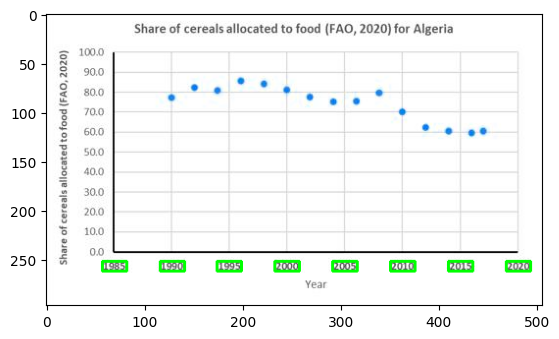

In [14]:
# visualize text_detection_ground_truths
import numpy as np
# shuffle
x_labels_text_detection_ground_truths = {k: x_labels_text_detection_ground_truths[k] for k in np.random.permutation(list(x_labels_text_detection_ground_truths.keys()))}
for image_name, polygon_text in x_labels_text_detection_ground_truths.items():
    image_path = os.path.join(TRAIN_IMAGE_FOLDER, image_name)
    image = cv2.imread(image_path)

    for line in polygon_text.splitlines():
        points = line.split(",dummy_text")[0].split(",")
        points = [int(x) for x in points]
        points = np.array(points).reshape(-1, 2)
        cv2.polylines(image, [points], True, (0, 255, 0), 2)

    plt.imshow(image)
    plt.show()
    break

In [ ]:
# figure(figsize=(8, 6), dpi=80)

# plt.imshow(image)
# plt.show()

In [15]:
num_item_from_source = {}
for item in ground_truths:
    if item["source"] not in num_item_from_source:
        num_item_from_source[item["source"]] = 0
    num_item_from_source[item["source"]] += 1

print("Number of items from each source: ", num_item_from_source)

Number of items from each source:  {'generated': 59460, 'extracted': 1118}


In [16]:
# item that has source = "extracted"
source_image_paths = []
for item in ground_truths:
    if item["source"] == "extracted":
        source_image_paths.append(os.path.join("train", item["file_name"]))

In [ ]:
from PIL import Image

Image.open(source_image_paths[10])

In [ ]:
# split ground truths into train and validation, validation images is all images from source = "extracted"
train_ground_truths = []
val_ground_truths = []

for item in ground_truths:
    if item["source"] != "extracted":
        train_ground_truths.append(item)

# split 50:50 extracted source images into train and validation
remain_ground_truths = []
for item in ground_truths:
    if item["source"] == "extracted":
        remain_ground_truths.append(item)

# set seed for reproducibility
import random
random.seed(42)
random.shuffle(remain_ground_truths)

for i in range(len(remain_ground_truths)):
    if i < len(remain_ground_truths) // 2:
        train_ground_truths.append(remain_ground_truths[i])
    else:
        val_ground_truths.append(remain_ground_truths[i])

print("Number of train ground truths: ", len(train_ground_truths))
print("Number of val ground truths: ", len(val_ground_truths))

In [ ]:
train_file_names = set([os.path.basename(item["file_name"]) for item in train_ground_truths])
val_file_names = set([os.path.basename(item["file_name"]) for item in val_ground_truths])

In [ ]:
# split keypoints ground truths into train and validation
train_keypoints_ground_truths = {}
val_keypoints_ground_truths = {}

for image_name, keypoints in keypoints_ground_truths.items():
    if image_name in train_file_names:
        train_keypoints_ground_truths[image_name] = keypoints
    elif image_name in val_file_names:
        val_keypoints_ground_truths[image_name] = keypoints

# save to json 
with open("train_keypoints_ground_truths.json", "w") as f:
    json.dump(train_keypoints_ground_truths, f)

with open("val_keypoints_ground_truths.json", "w") as f:
    json.dump(val_keypoints_ground_truths, f)

In [ ]:
# !pip install jsonlines

In [ ]:
# copy all images to train/images and val/images
import shutil

# make dirs for validation
os.makedirs("./validation/images/", exist_ok=True)

for gt in tqdm(val_ground_truths):
    shutil.copy2(os.path.join("./train", gt["file_name"]), "./validation/images/")


In [ ]:
# save to jsonl file
import jsonlines

with jsonlines.open("./train/metadata.jsonl", mode="w") as writer:
    writer.write_all(train_ground_truths)

with jsonlines.open("./validation/metadata.jsonl", mode="w") as writer:
    writer.write_all(val_ground_truths)

In [18]:
# temporary
text_gts = y_labels_text_detection_ground_truths

val_image_names = os.listdir("./validation/images")
train_image_names = set(text_gts.keys()) - set(val_image_names)

print("train_image_names: ", len(train_image_names))
print("val_image_names: ", len(val_image_names))

TRAIN_TEXT_DETECTION_FOLDER = "./y_labels_train_gts"
VAL_TEXT_DETECTION_FOLDER = "./y_labels_val_gts"

# makedirs
os.makedirs(TRAIN_TEXT_DETECTION_FOLDER, exist_ok=True)
os.makedirs(VAL_TEXT_DETECTION_FOLDER, exist_ok=True)

for image_name, text in tqdm(text_gts.items()):
    if image_name in train_image_names:
        with open(os.path.join(TRAIN_TEXT_DETECTION_FOLDER, image_name + ".txt"), "w") as f:
            f.write(text)
    else:
        with open(os.path.join(VAL_TEXT_DETECTION_FOLDER, image_name + ".txt"), "w") as f:
            f.write(text)

# train_list.txt and val_list.txt
with open("./y_labels_train_list.txt", "w") as f:
    for image_name in train_image_names:
        f.write(image_name + "\n")

with open("./y_labels_val_list.txt", "w") as f:
    for image_name in val_image_names:
        f.write(image_name + "\n") 

train_image_names:  60019
val_image_names:  559


100%|██████████| 60578/60578 [00:01<00:00, 31476.46it/s]


In [ ]:
max_len = 0
lens = []

for gt in ground_truths:
    l = len(gt["ground_truth"]["gt_parse"]["value"])
    lens.append(l)
    if l > max_len:
        max_len = l

print("Max number of data-series: ", max_len)

In [ ]:
# draw histogram of length of data-series
import matplotlib.pyplot as plt
plt.hist(lens, bins=10)

In [ ]:
import numpy as np
import Levenshtein as lev
from sklearn.metrics import r2_score


def sigmoid2(x):
    return 2 - 2 / (1 + np.exp(-x))


def rmse(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.sqrt(np.mean(np.square(y_true - y_pred)))


def nrmse(y_true, y_pred):
    if len(y_true) != len(y_pred):
        return 0
    # y_bar = np.array([np.mean(y_true) for _ in range(len(y_true))])
    # return sigmoid2(rmse(y_true, y_pred) / rmse(y_true, y_bar))
    return sigmoid2(1 - r2_score(y_true, y_pred))


def nlev(y_true, y_pred):
    if len(y_true) != len(y_pred):
        return 0
    return sigmoid2(sum([lev.distance(y_t, y_p) for y_t, y_p in zip(y_true, y_pred)]) / sum([len(y) for y in y_true]))


def calculate_score(pred, gt):
    if pred["class"] != gt["class"]:
        return 0

    if len(pred["value"]) != len(gt["value"]):
        return 0
    
    if len(pred["value"]) == 0 and len(gt["value"]) == 0:
        return 1

    pred_xs = [x["x"] for x in pred["value"]]
    pred_ys = [x["y"] for x in pred["value"]]

    gt_xs = [x["x"] for x in gt["value"]]
    gt_ys = [x["y"] for x in gt["value"]]

    score = 0
    if isinstance(gt_xs[0], str):
        score += nlev(pred_xs, gt_xs)
    else:
        score += nrmse(pred_xs, gt_xs)

    if isinstance(gt_ys[0], str):
        score += nlev(pred_ys, gt_ys)
    else:
        score += nrmse(pred_ys, gt_ys)

    return score / 2

In [ ]:
calculate_score(
    {
        'class': 'scatter',
        'value': [
            {'x': 1949.4201, 'y': 66.683},
            {'x': 1954.6107, 'y': 66.2785},
            {'x': 1959.9936, 'y': 65.6718},
            {'x': 1964.7997, 'y': 64.0537},
        ]
    },
    {
        'class': 'scatter',
        'value': [
            {'x': 1949.4201, 'y': 6.683},
            {'x': 1954.6107, 'y': 66.2785},
            {'x': 1959.9936, 'y': 65.6718},
            {'x': 1964.7997, 'y': 64.0537},
        ]
    },
)

### Prepare YoloX data

In [ ]:
# convert list of x, y pairs to coco format
def convert_keypoints_data_to_coco_format(gts, folder="train"):
    images = []
    annotations = []

    classes = ["value", "x", "y", "x_label", "y_label"]

    for i, (k, v) in tqdm(enumerate(gts.items())):
        path = os.path.join(f"./{folder}/images/", k)
        img = cv2.imread(path)
        images.append({
            "id": i,
            "file_name": k,
            "width": img.shape[1],
            "height": img.shape[0],
        })

        for c in classes:
            if c == "value":
                for j, point in enumerate(v[c]):
                    bbox = [point["x_pixel"] - 5, point["y_pixel"] - 5, 10, 10]
                    annotations.append({
                        "id": len(annotations),
                        "image_id": i,
                        "category_id": 1,
                        "bbox": bbox,
                        "iscrowd": 0,
                        "area": 100,
                    })
            elif c in ["x", "y"]:
                for j, point in enumerate(v[c]):
                    bbox = [point["tick_pt"]["x"] - 5, point["tick_pt"]["y"] - 5, 10, 10]
                    annotations.append({
                        "id": len(annotations),
                        "image_id": i,
                        "category_id": 2 if c == "x" else 3,
                        "bbox": bbox,
                        "iscrowd": 0,
                        "area": 100,
                    })
            else:
                for j, point in enumerate(v[c]):
                    bbox = [point[0], point[1], point[2] - point[0], point[3] - point[1]]
                    annotations.append({
                        "id": len(annotations),
                        "image_id": i,
                        "category_id": 4 if c == "x_label" else 5,
                        "bbox": bbox,
                        "iscrowd": 0,
                        "area": 100,
                    })

    coco_annotations = {
        "images": images,
        "annotations": annotations,
        "categories": [
            {
                "id": 1,
                "name": "value",
                "supercategory": "value",
            },
            {
                "id": 2,
                "name": "x",
                "supercategory": "x",
            },
            {
                "id": 3,
                "name": "y",
                "supercategory": "y",
            },
            {
                "id": 4,
                "name": "x_label",
                "supercategory": "x_label",
            },
            {
                "id": 5,
                "name": "y_label",
                "supercategory": "y_label",
            },
        ],
        "type": "instances",
    }

    return coco_annotations


# convert to coco format
train_coco_annotations = convert_keypoints_data_to_coco_format(train_keypoints_ground_truths)
val_coco_annotations = convert_keypoints_data_to_coco_format(val_keypoints_ground_truths)

In [ ]:
# save to json
with open("annotations/train_coco_annotations.json", "w") as writer:
    json.dump(train_coco_annotations, writer)

with open("annotations/val_coco_annotations.json", "w") as writer:
    json.dump(val_coco_annotations, writer)

In [ ]:
# visualize one image with coco annotations to check if everything is correct
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pycocotools.coco import COCO

def visualize_coco_annotations(coco_annotations, image_id):
    coco = COCO()
    coco.dataset = coco_annotations
    coco.createIndex()

    img = coco.loadImgs(image_id)[0]
    I = cv2.imread(os.path.join("./validation/images/", img["file_name"]))
    plt.axis("off")
    plt.imshow(I)

    annIds = coco.getAnnIds(imgIds=img["id"])
    anns = coco.loadAnns(annIds)

    for ann in anns:
        bbox = ann["bbox"]
        # different colors for different classes
        if ann["category_id"] == 1:
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor="r", facecolor="none")
        elif ann["category_id"] == 2:
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor="g", facecolor="none")
        elif ann["category_id"] == 3:
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor="b", facecolor="none")
        elif ann["category_id"] == 4:
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor="y", facecolor="none")
        elif ann["category_id"] == 5:
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor="c", facecolor="none")
        plt.gca().add_patch(rect)
    
    # increase size of image
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.show()

index = random.randint(0, len(val_coco_annotations["images"]))
visualize_coco_annotations(val_coco_annotations, index)

print(val_coco_annotations["images"][index])

In [ ]:
# # wrong data: 374fcc8c9542.jpg, a80688cb2101.jpg, b9507ab4e9fc.jpg, 3d0b1f8e6f61.jpg, 907a4cbc9ff1.jpg, fbf4820dc2c1.jpg

# image_name = "374fcc8c9542.jpg"
# points = train_keypoints_ground_truths[image_name]["value"]

# # visualize 
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches

# def visualize_points(img, points):
#     plt.axis("off")
#     plt.imshow(img)

#     for point in points:
#         rect = patches.Rectangle((point["x_pixel"] - 5, point["y_pixel"] - 5), 10, 10, linewidth=1, edgecolor="r", facecolor="none")
#         plt.gca().add_patch(rect)
    
#     # increase size of image
#     fig = plt.gcf()
#     fig.set_size_inches(18.5, 10.5)
#     plt.show()

# img = cv2.imread(os.path.join("./train/images/", image_name))
# visualize_points(img, points)
